## LLM Pipeline results
This notebook evaluates the results form the LLM Pipeline. 
1. Check whether results from LLM, Ground Truth, Human Judgements and Maxp Similarity correlate or which results have the highest agreement
2. Compute the overlap between most relevant regions for the LLM decision and the heatmaps
3. Compute overall statistics about the relevance distribution across different facial regions

## 1. Agreement across Models

In [ ]:
import pandas as pd
from facesim3d import local_paths


results_dir = local_paths.DIR_LLM_ANALYSIS_RESULTS
df = pd.read_csv(os.path.join(results_dir, "llm_pipeline_#10000.csv"))

# Ensure numeric types
for col in ["ground_truth", "llm_answer", "human_judgement", "maxp_sim"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df.head()

,index,ground_truth,llm_answer,llm_regions,human_judgement,maxp_sim,llm_prediction_id
0,53914,2,2,mouth;nose_tip;chin,2,0,5
1,44836,1,1,left_cheek;right_cheek,1,2,27
2,135922,1,0,left_eye;right_eye;nose_tip,0,1,4
3,84857,2,2,mouth;nose_tip;chin,0,2,58
4,18173,2,0,mouth;nose_tip;chin,2,2,44


### Accuracy (compared to ground truth)

In [2]:
acc_llm = (df["llm_answer"] == df["ground_truth"]).mean()
acc_hj = (df["human_judgement"] == df["ground_truth"]).mean()
acc_maxp = (df["maxp_sim"] == df["ground_truth"]).mean()

print(f"LLM Accuracy: {acc_llm:.3f}")
print(f"Human Judgment Model Accuracy: {acc_hj:.3f}")
print(f"MaxP Sim Model Accuracy: {acc_maxp:.3f}")

LLM Accuracy: 0.413
Human Judgment Model Accuracy: 0.577
MaxP Sim Model Accuracy: 0.364


### Agreement across Models and Ground Truth

In [3]:
from sklearn.metrics import cohen_kappa_score

# Compute all pairwise Cohen’s kappa scores
pairs = [
    ("LLM vs HJ", "llm_answer", "human_judgement"),
    ("LLM vs MaxP", "llm_answer", "maxp_sim"),
    ("HJ vs MaxP", "human_judgement", "maxp_sim"),
    ("LLM vs GT", "llm_answer", "ground_truth"),
    ("HJ vs GT", "human_judgement", "ground_truth"),
    ("MaxP vs GT", "maxp_sim", "ground_truth"),
]

# Calculate and print neatly
scores = pd.DataFrame()
print("Cohen's Kappa Agreement Scores")
for label, col1, col2 in pairs:
    kappa = cohen_kappa_score(df[col1], df[col2])
    scores['kappa'] = kappa
    scores['label'] = label
    print(f"{label:15s}: {kappa:.3f}")
scores

Cohen's Kappa Agreement Scores
LLM vs HJ      : 0.235
LLM vs MaxP    : 0.090
HJ vs MaxP     : 0.097
LLM vs GT      : 0.124
HJ vs GT       : 0.365
MaxP vs GT     : 0.047


,kappa,label


### 2. Agreement of Regions between LLM choice and the Relevance distribution
Loop over all heads and compare what the LLM suggests as relevant regions and what are the most relevant regions in terms of accumulating the most relevance in LRP heatmaps on average.

#### LLM Statistics of most important regions

In [4]:
# All unique values in the column
unique_ids = list(df["llm_prediction_id"].unique())

# Split regions into separate entries (since they are separated by ;)
df_exploded = df.assign(region=df["llm_regions"].str.split(";")).explode("region")
df_exploded.head()

,index,ground_truth,llm_answer,llm_regions,human_judgement,maxp_sim,llm_prediction_id,region
0,53914,2,2,mouth;nose_tip;chin,2,0,5,mouth
0,53914,2,2,mouth;nose_tip;chin,2,0,5,nose_tip
0,53914,2,2,mouth;nose_tip;chin,2,0,5,chin
1,44836,1,1,left_cheek;right_cheek,1,2,27,left_cheek
1,44836,1,1,left_cheek;right_cheek,1,2,27,right_cheek


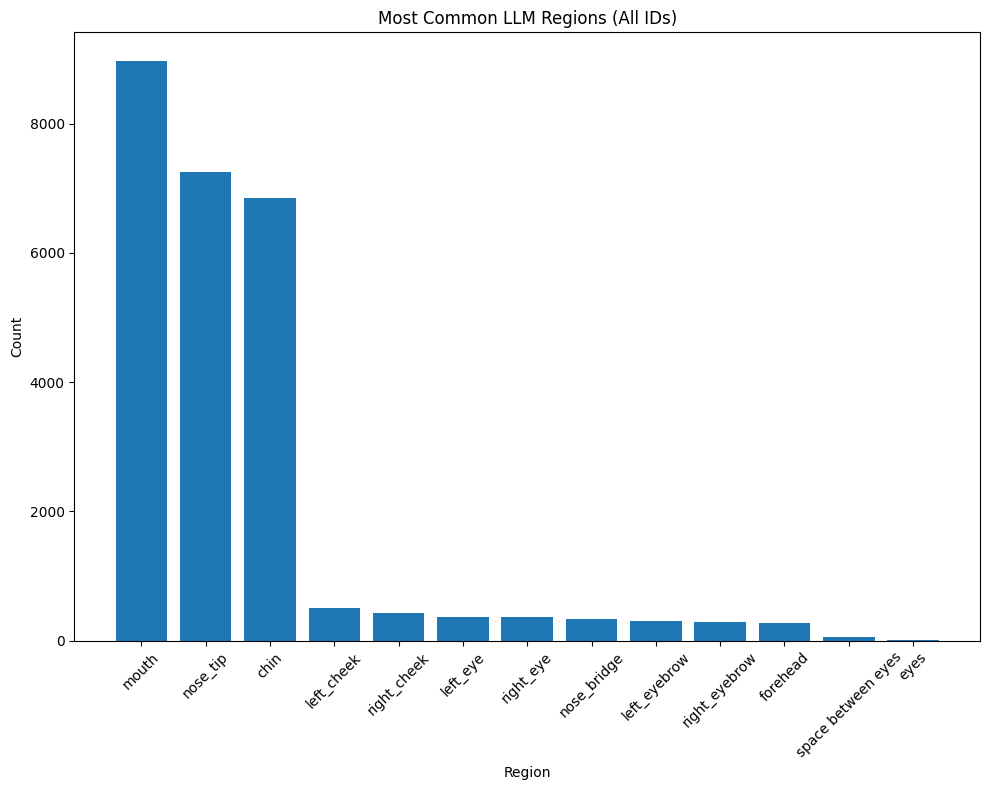

In [ ]:
import matplotlib.pyplot as plt

region_counts_overall = (
    df_exploded["region"].value_counts().reset_index()
)
region_counts_overall.columns = ["region", "count"]

plt.figure(figsize=(10, 8))
plt.bar(region_counts_overall["region"], region_counts_overall["count"])
plt.title("Most Common LLM Regions (All IDs)")
plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("llm_most_common_regions_barplot.png")
plt.show()


In [9]:
# Group by prediction ID and region, count occurrences
region_counts = (df_exploded.groupby(["llm_prediction_id", "region"]).size().reset_index(name="count"))  
region_counts = region_counts.sort_values(["llm_prediction_id", "count"], ascending=[True, False])

In [10]:
print("All region counts:")
print(region_counts)

All region counts:
     llm_prediction_id         region  count
3                    1          mouth     51
5                    1       nose_tip     46
0                    1           chin     40
1                    1     left_cheek     20
6                    1    right_cheek     19
..                 ...            ...    ...
797                100     left_cheek     46
801                100    right_cheek     44
796                100       forehead      1
798                100   left_eyebrow      1
802                100  right_eyebrow      1

[803 rows x 3 columns]


In [11]:
# For each ID, pick the region(s) with the highest count
most_common_regions = (region_counts.loc[region_counts.groupby("llm_prediction_id")["count"].idxmax()])
print("\nMost common region(s) per ID:")
print(most_common_regions)


Most common region(s) per ID:
     llm_prediction_id      region  count
3                    1       mouth     51
11                   2       mouth     53
22                   3    nose_tip     54
30                   4       mouth     69
43                   5    nose_tip     67
..                 ...         ...    ...
766                 96       mouth    104
771                 97  left_cheek     89
780                 98       mouth     73
790                 99       mouth     99
799                100       mouth     87

[100 rows x 3 columns]


In [34]:
color_map = {
    "space between eyes": "#1f77b4",   # blue
    "forehead":            "#ff7f0e",   # orange
    "chin":                "#2ca02c",   # green
    "right_eye":           "#d62728",   # red
    "right_cheek":         "#9467bd",   # purple
    "nose_tip":            "#8c564b",   # brown
    "mouth":               "#17becf",   # teal
    "right_eyebrow":       "#7f7f7f",   # gray
    "left_eyebrow":        "#bcbd22",   # yellow-green
    "left_cheek":          "#e377c2",   # pink
    "left_eye":            "#aec7e8",   # light blue
    "nose_bridge":         "#ffbb78",   # peach
}

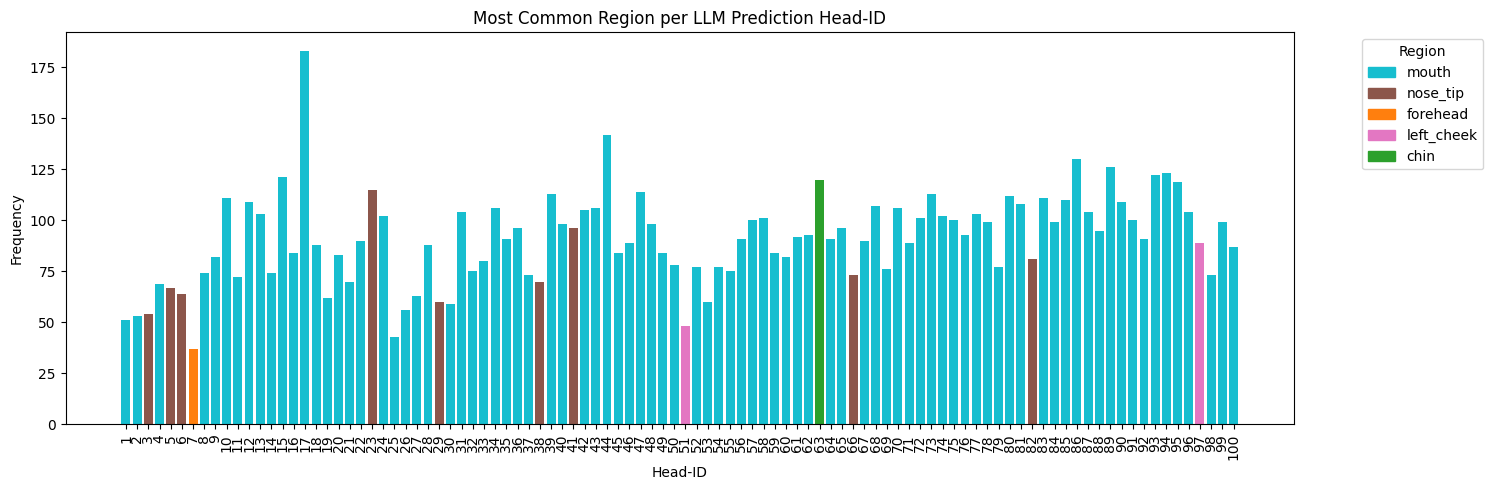

In [35]:
# Get a unique color per region
regions = most_common_regions["region"].unique()
#color_map = {region: color for region, color in zip(regions, plt.cm.tab10.colors)}

# Plot
plt.figure(figsize=(15, 5))
bars = plt.bar(
    most_common_regions["llm_prediction_id"].astype(str),
    most_common_regions["count"],
    color=[color_map[r] for r in most_common_regions["region"]]
)

plt.title("Most Common Region per LLM Prediction Head-ID")
plt.xlabel("Head-ID")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

# Add legend
handles = [plt.Rectangle((0,0),1,1,color=color_map[r]) for r in regions]
plt.legend(handles, regions, title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("llm_most_common_region_per_ID.png")
plt.show()


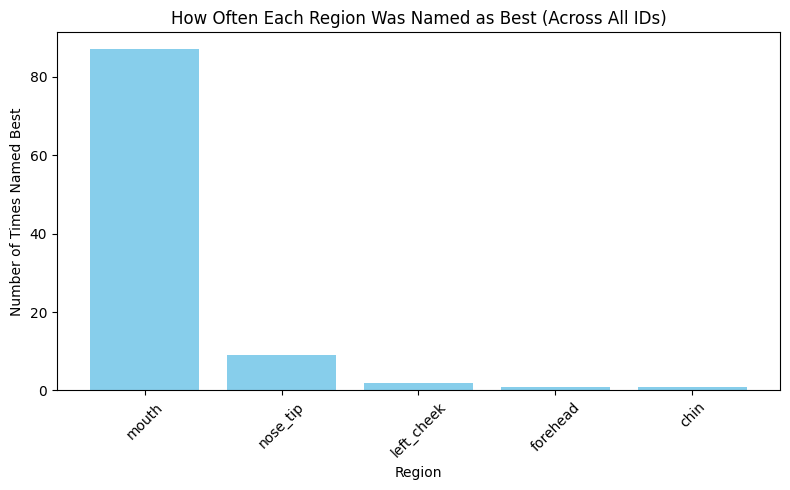

In [10]:
region_best_counts = (
    most_common_regions["region"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "region", "region": "times_best"})
)

plt.figure(figsize=(8, 5))
plt.bar(region_best_counts["region"], region_best_counts["times_best"], color="skyblue")
plt.title("How Often Each Region Was Named as Best (Across All IDs)")
plt.xlabel("Region")
plt.ylabel("Number of Times Named Best")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Mediapipe statistics of the most important regions regarding to the relevance distribution

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# Path to the mediapipe data
mediapipe_results_dir = local_paths.DIR_REGION_ANALYSIS_RESULTS
csv_path = "relevance_per_region_dataset_hj.csv"

df_regions = pd.read_csv(csv_path)
df_regions["llm_prediction_id"] = (df_regions["image_name"].str.extract(r"(\d+)").astype(int))
print(df_regions.head())

      mouth  nose_tip  nose_bridge  left_eye  space between eyes  forehead  \
0  0.000315  0.000310     0.000248  0.000194            0.000405 -0.000040   
1 -0.001399 -0.002213    -0.000527 -0.001067           -0.002133 -0.000003   
2 -0.000035  0.000232     0.000118  0.000249            0.001035  0.000008   
3  0.000170  0.000165    -0.000014 -0.000009           -0.000092 -0.000046   
4  0.000503  0.000636     0.000484  0.000481            0.000413 -0.000014   

       chin  left_cheek  left_eyebrow  right_eye  right_cheek  right_eyebrow  \
0  0.000056    0.000066      0.000046   0.000203     0.000084       0.000183   
1 -0.000394   -0.000444     -0.000756  -0.000911    -0.000559      -0.000660   
2 -0.000009    0.000045      0.000177   0.000156     0.000045       0.000182   
3  0.000303    0.000027     -0.000012  -0.000054     0.000022      -0.000060   
4  0.000207    0.000144      0.000367   0.001012     0.000160       0.000758   

             image_name  llm_prediction_id  
0  he

In [17]:
region_cols = [c for c in df_regions.columns if c not in ["image_name", "llm_prediction_id"]]
region_data = df_regions[region_cols]

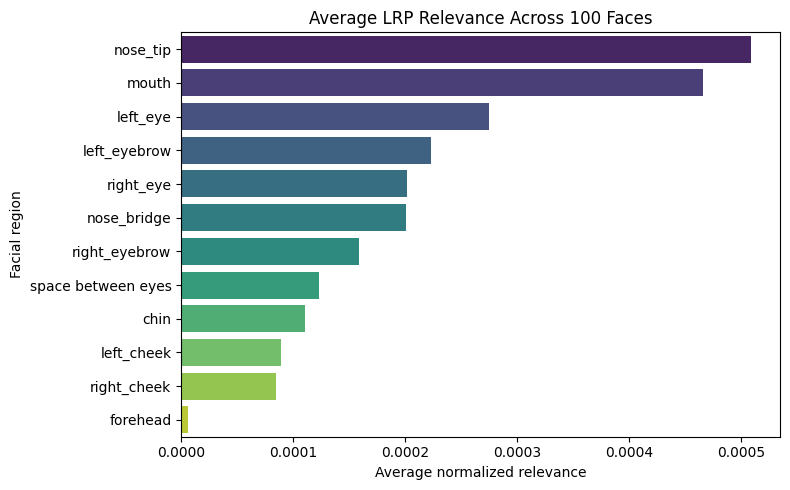

In [18]:
mean_scores = region_data.mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sn.barplot(x=mean_scores.values, y=mean_scores.index, palette="viridis")
plt.xlabel("Average normalized relevance")
plt.ylabel("Facial region")
plt.title("Average LRP Relevance Across 100 Faces")
plt.tight_layout()
plt.show()

#### Comparison
1. For the best region per ID

In [37]:
print("\nMost common region(s) per ID:")
print(most_common_regions)


Most common region(s) per ID:
     llm_prediction_id      region  count
3                    1       mouth     51
11                   2       mouth     53
22                   3    nose_tip     54
30                   4       mouth     69
43                   5    nose_tip     67
..                 ...         ...    ...
766                 96       mouth    104
771                 97  left_cheek     89
780                 98       mouth     73
790                 99       mouth     99
799                100       mouth     87

[100 rows x 3 columns]


In [38]:
# find region with the max numeric value per ID
df_regions["best_numeric_region"] = df_regions[region_cols].idxmax(axis=1)
df_regions.head()

,mouth,nose_tip,nose_bridge,left_eye,space between eyes,forehead,chin,left_cheek,left_eyebrow,right_eye,right_cheek,right_eyebrow,image_name,llm_prediction_id,best_numeric_region
0,0.000315,0.000310,0.000248,0.000194,0.000405,-0.000040,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183,head-001_frontal.png,1,space between eyes
1,-0.001399,-0.002213,-0.000527,-0.001067,-0.002133,-0.000003,-0.000394,-0.000444,-0.000756,-0.000911,-0.000559,-0.000660,head-002_frontal.png,2,forehead
2,-0.000035,0.000232,0.000118,0.000249,0.001035,0.000008,-0.000009,0.000045,0.000177,0.000156,0.000045,0.000182,head-003_frontal.png,3,space between eyes
3,0.000170,0.000165,-0.000014,-0.000009,-0.000092,-0.000046,0.000303,0.000027,-0.000012,-0.000054,0.000022,-0.000060,head-004_frontal.png,4,chin
4,0.000503,0.000636,0.000484,0.000481,0.000413,-0.000014,0.000207,0.000144,0.000367,0.001012,0.000160,0.000758,head-005_frontal.png,5,right_eye


['space between eyes' 'forehead' 'chin' 'right_eye' 'right_cheek'
 'nose_tip' 'mouth' 'right_eyebrow' 'left_eyebrow' 'left_cheek' 'left_eye'
 'nose_bridge']


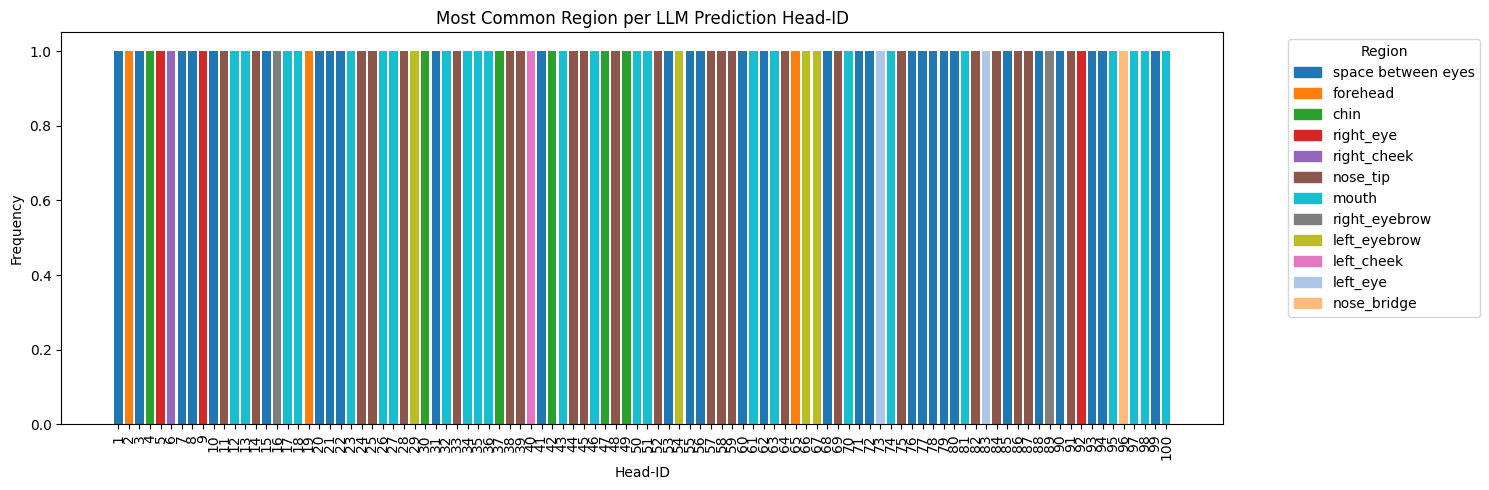

In [42]:
# Get a unique color per region
regions = df_regions["best_numeric_region"].unique()
print(regions)

# dummy variables 
heights = [1] * len(df_regions)

# Plot
plt.figure(figsize=(15, 5))
bars = plt.bar(
    df_regions["llm_prediction_id"].astype(str),
    heights,
    color=[color_map[r] for r in df_regions["best_numeric_region"]]
)

plt.title("Most Common Region per LLM Prediction Head-ID")
plt.xlabel("Head-ID")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

# Add legend
handles = [plt.Rectangle((0,0),1,1,color=color_map[r]) for r in regions]
plt.legend(handles, regions, title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("regional_analysis_most_common_region_per_ID.png")
plt.show()


In [21]:
df_merged = df_regions.merge(most_common_regions[["llm_prediction_id", "region"]],on="llm_prediction_id",how="left",suffixes=("", "_llm_most_common"))
df_merged.head()

,mouth,nose_tip,nose_bridge,left_eye,space between eyes,forehead,chin,left_cheek,left_eyebrow,right_eye,right_cheek,right_eyebrow,image_name,llm_prediction_id,best_numeric_region,region
0,0.000315,0.000310,0.000248,0.000194,0.000405,-0.000040,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183,head-001_frontal.png,1,space between eyes,mouth
1,-0.001399,-0.002213,-0.000527,-0.001067,-0.002133,-0.000003,-0.000394,-0.000444,-0.000756,-0.000911,-0.000559,-0.000660,head-002_frontal.png,2,forehead,mouth
2,-0.000035,0.000232,0.000118,0.000249,0.001035,0.000008,-0.000009,0.000045,0.000177,0.000156,0.000045,0.000182,head-003_frontal.png,3,space between eyes,nose_tip
3,0.000170,0.000165,-0.000014,-0.000009,-0.000092,-0.000046,0.000303,0.000027,-0.000012,-0.000054,0.000022,-0.000060,head-004_frontal.png,4,chin,mouth
4,0.000503,0.000636,0.000484,0.000481,0.000413,-0.000014,0.000207,0.000144,0.000367,0.001012,0.000160,0.000758,head-005_frontal.png,5,right_eye,nose_tip


In [55]:
# compute the matches
df_merged["match"] = (df_merged["best_numeric_region"] == df_merged["region"])

print(df_merged[["llm_prediction_id", "best_numeric_region", "region", "match"]])

    llm_prediction_id best_numeric_region      region  match
0                   1  space between eyes       mouth  False
1                   2            forehead       mouth  False
2                   3  space between eyes    nose_tip  False
3                   4                chin       mouth  False
4                   5           right_eye    nose_tip  False
..                ...                 ...         ...    ...
95                 96         nose_bridge       mouth  False
96                 97               mouth  left_cheek  False
97                 98               mouth       mouth   True
98                 99  space between eyes       mouth  False
99                100               mouth       mouth   True

[100 rows x 4 columns]


In [56]:
match_rate = df_merged["match"].mean()
print(f"Overall match rate: {match_rate:.2%}")

Overall match rate: 22.00%


In [57]:
print("Matching heads:")
print(df_merged[df_merged["match"]][["llm_prediction_id", "best_numeric_region", "region"]])
print(f"Total: {len(df_merged[df_merged['match']][['llm_prediction_id', 'best_numeric_region', 'region']])} IDs.")

Matching heads:
    llm_prediction_id best_numeric_region    region
11                 12               mouth     mouth
12                 13               mouth     mouth
16                 17               mouth     mouth
17                 18               mouth     mouth
25                 26               mouth     mouth
26                 27               mouth     mouth
31                 32               mouth     mouth
33                 34               mouth     mouth
34                 35               mouth     mouth
35                 36               mouth     mouth
37                 38            nose_tip  nose_tip
42                 43               mouth     mouth
45                 46               mouth     mouth
49                 50               mouth     mouth
60                 61               mouth     mouth
69                 70               mouth     mouth
73                 74               mouth     mouth
80                 81               mouth     mo

#### Comparison
2. For the top3 regions across all samples

In [58]:
# join regions in a list
df["llm_region_list"] = df["llm_regions"].str.split(";")

In [63]:
region_cols = [c for c in df_regions.columns if c not in ["image_name", "llm_prediction_id", "best_numeric_region", "llm_regions"]]

In [66]:
# merge again
df_merged = df_regions.merge(df[["llm_prediction_id", "llm_region_list"]],on="llm_prediction_id",how="left",suffixes=("", "_llm_most_common"))
df_merged.head()

,mouth,nose_tip,nose_bridge,left_eye,space between eyes,forehead,chin,left_cheek,left_eyebrow,right_eye,right_cheek,right_eyebrow,image_name,llm_prediction_id,best_numeric_region,top3_numeric_regions,llm_region_list
0,0.000315,0.00031,0.000248,0.000194,0.000405,-0.00004,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183,head-001_frontal.png,1,space between eyes,"[space between eyes, mouth, nose_tip]","[left_cheek, right_cheek, chin]"
1,0.000315,0.00031,0.000248,0.000194,0.000405,-0.00004,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183,head-001_frontal.png,1,space between eyes,"[space between eyes, mouth, nose_tip]","[mouth, nose_tip, chin]"
2,0.000315,0.00031,0.000248,0.000194,0.000405,-0.00004,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183,head-001_frontal.png,1,space between eyes,"[space between eyes, mouth, nose_tip]","[mouth, nose_tip, chin]"
3,0.000315,0.00031,0.000248,0.000194,0.000405,-0.00004,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183,head-001_frontal.png,1,space between eyes,"[space between eyes, mouth, nose_tip]",[mouth]
4,0.000315,0.00031,0.000248,0.000194,0.000405,-0.00004,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183,head-001_frontal.png,1,space between eyes,"[space between eyes, mouth, nose_tip]",[mouth]


In [67]:
def get_top3_regions(row):
    # Select only numeric columns, force conversion in case of weird types
    numeric_part = pd.to_numeric(row[region_cols], errors='coerce')
    return numeric_part.nlargest(3).index.tolist()

df_regions["top3_numeric_regions"] = df_regions.apply(get_top3_regions, axis=1)

In [70]:
df_merged["match"] = df_merged.apply(
    lambda x: (
        isinstance(x["llm_region_list"], list)
        and isinstance(x["top3_numeric_regions"], list)
        and any(region in x["llm_region_list"] for region in x["top3_numeric_regions"])
    ),
    axis=1
)

print(f"Match rate: {df_merged['match'].mean():.2%}")

Match rate: 73.99%


In [74]:
non_matches = df_merged[~df_merged["match"]]
print(f"Total: {len(non_matches)} of 10000 entries without a match.")

Total: 2601 of 10000 entries without a match.


In [75]:
non_matches.head()

,mouth,nose_tip,nose_bridge,left_eye,space between eyes,forehead,chin,left_cheek,left_eyebrow,right_eye,right_cheek,right_eyebrow,image_name,llm_prediction_id,best_numeric_region,top3_numeric_regions,llm_region_list,match
0,0.000315,0.00031,0.000248,0.000194,0.000405,-0.00004,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183,head-001_frontal.png,1,space between eyes,"[space between eyes, mouth, nose_tip]","[left_cheek, right_cheek, chin]",False
5,0.000315,0.00031,0.000248,0.000194,0.000405,-0.00004,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183,head-001_frontal.png,1,space between eyes,"[space between eyes, mouth, nose_tip]","[left_cheek, right_cheek]",False
13,0.000315,0.00031,0.000248,0.000194,0.000405,-0.00004,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183,head-001_frontal.png,1,space between eyes,"[space between eyes, mouth, nose_tip]","[left_cheek, right_cheek]",False
15,0.000315,0.00031,0.000248,0.000194,0.000405,-0.00004,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183,head-001_frontal.png,1,space between eyes,"[space between eyes, mouth, nose_tip]","[left_cheek, right_cheek]",False
17,0.000315,0.00031,0.000248,0.000194,0.000405,-0.00004,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183,head-001_frontal.png,1,space between eyes,"[space between eyes, mouth, nose_tip]","[left_cheek, right_cheek]",False
